<a href="https://colab.research.google.com/github/chillukamaripranaya143/Alzheimer_mini/blob/main/SE_RESNET%2BVGGNET.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install kaggle --quiet

# Upload your Kaggle API key
from google.colab import files
files.upload()  # Upload kaggle.json from your Kaggle account

# Setup Kaggle API credentials
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Download dataset
!kaggle datasets download -d ashrafulhossenakash/alzheimer-disease-dataset

# Unzip dataset
!unzip -q alzheimer-disease-dataset.zip -d /content/
!ls /content/Dataset


Saving kaggle.json to kaggle.json
Dataset URL: https://www.kaggle.com/datasets/ashrafulhossenakash/alzheimer-disease-dataset
License(s): CC0-1.0
 90% 310M/346M [00:00<00:00, 864MB/s] 
100% 346M/346M [00:00<00:00, 709MB/s]
ls: cannot access '/content/Dataset': No such file or directory


In [2]:
# Requirements: tensorflow>=2.10, sklearn, matplotlib, seaborn
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, Model, Input
from tensorflow.keras.applications import ResNet50, DenseNet121
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from sklearn.metrics import classification_report, confusion_matrix, cohen_kappa_score, f1_score, recall_score, precision_score
import matplotlib.pyplot as plt
import seaborn as sns



In [3]:
base_dir = "/content/Alzheimer_Dataset_V2"   # change if needed
train_dir = os.path.join(base_dir, "train")
val_dir   = os.path.join(base_dir, "val")
test_dir  = os.path.join(base_dir, "test")

In [6]:
import tensorflow as tf
from tensorflow.keras import layers, models, applications
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint


In [7]:
img_size = (224, 224)
batch_size = 32

train_ds = image_dataset_from_directory(
    train_dir,
    image_size=img_size,
    batch_size=batch_size,
    shuffle=True
)

val_ds = image_dataset_from_directory(
    val_dir,
    image_size=img_size,
    batch_size=batch_size,
    shuffle=False
)

test_ds = image_dataset_from_directory(
    test_dir,
    image_size=img_size,
    batch_size=batch_size,
    shuffle=False
)

class_names = train_ds.class_names
print("Detected Classes:", class_names)

# Prefetch for performance
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.prefetch(AUTOTUNE)
val_ds   = val_ds.prefetch(AUTOTUNE)
test_ds  = test_ds.prefetch(AUTOTUNE)


Found 23788 files belonging to 4 classes.
Found 5097 files belonging to 4 classes.
Found 5099 files belonging to 4 classes.
Detected Classes: ['MildDemented', 'ModerateDemented', 'NonDemented', 'VeryMildDemented']


In [22]:
import numpy as np
import matplotlib.pyplot as plt

# Get class names
# class_names = train_ds.class_names
# print("Class Names:", class_names)

# Extract all labels from the training dataset
train_labels = np.concatenate([y for x, y in train_ds], axis=0)

# Count how many samples per class
unique, counts = np.unique(train_labels, return_counts=True)

# Print the counts
print("\n📊 Number of training samples per class:")
for cls, count in zip(class_names, counts):
    print(f"{cls}: {count}")


📊 Number of training samples per class:
MildDemented: 6272
ModerateDemented: 4524
NonDemented: 6720
VeryMildDemented: 6272


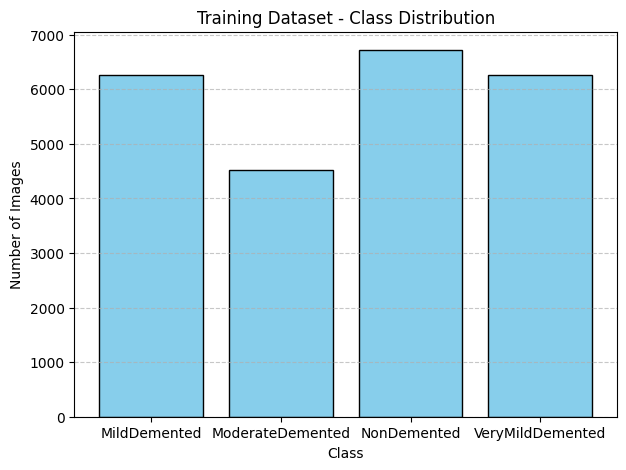

In [23]:
plt.figure(figsize=(7,5))

plt.bar(class_names, counts, color='skyblue', edgecolor='black')
plt.title("Training Dataset - Class Distribution")
plt.xlabel("Class")
plt.ylabel("Number of Images")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


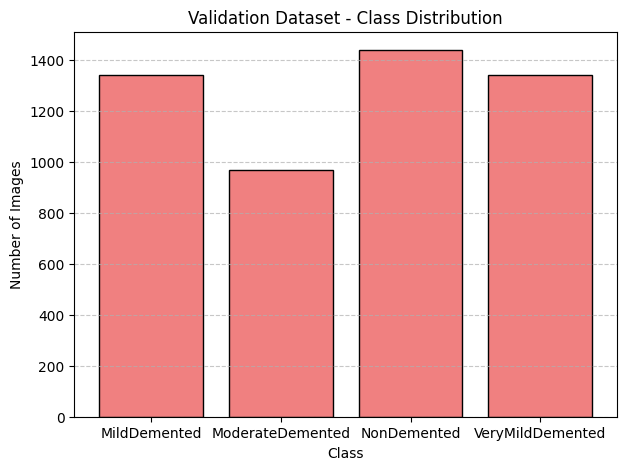

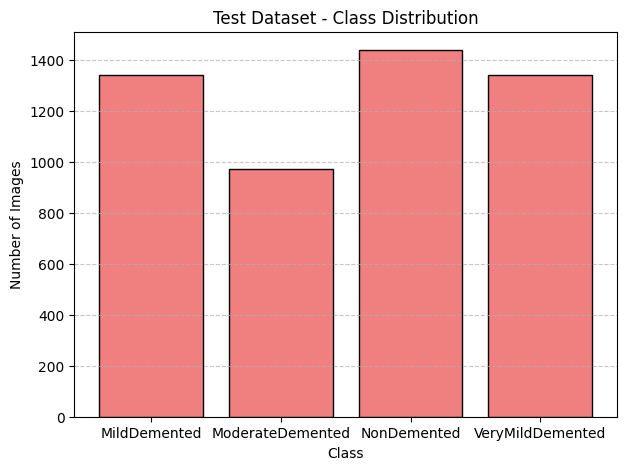

In [25]:
def plot_class_distribution(dataset, title):
    labels = np.concatenate([y for x, y in dataset], axis=0)
    unique, counts = np.unique(labels, return_counts=True)

    plt.figure(figsize=(7,5))
    plt.bar([class_names[i] for i in unique], counts, color='lightcoral', edgecolor='black')
    plt.title(title)
    plt.xlabel("Class")
    plt.ylabel("Number of Images")
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

plot_class_distribution(val_ds, "Validation Dataset - Class Distribution")
plot_class_distribution(test_ds, "Test Dataset - Class Distribution")


In [8]:
# ======================
# 2. DATA AUGMENTATION
# ======================
data_augmentation = models.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
    layers.RandomBrightness(0.1)
])


In [9]:
# ======================
# 3. SE-RESNET FEATURE EXTRACTOR
# ======================
def squeeze_excite_block(input_tensor, ratio=16):
    filters = input_tensor.shape[-1]
    se = layers.GlobalAveragePooling2D()(input_tensor)
    se = layers.Dense(filters // ratio, activation='relu')(se)
    se = layers.Dense(filters, activation='sigmoid')(se)
    se = layers.Multiply()([input_tensor, se])
    return se

def se_resnet50(input_shape=(224, 224, 3)):
    base = applications.ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)
    x = base.output
    x = squeeze_excite_block(x)
    x = layers.GlobalAveragePooling2D()(x)
    model = models.Model(inputs=base.input, outputs=x)
    return model

In [10]:
# ======================
# 4. VGG-STYLE CLASSIFIER
# ======================
def vgg_classifier(input_tensor, num_classes):
    x = layers.Dense(512, activation='relu')(input_tensor)
    x = layers.Dropout(0.5)(x)
    x = layers.Dense(256, activation='relu')(x)
    x = layers.Dropout(0.3)(x)
    output = layers.Dense(num_classes, activation='softmax')(x)
    return output

In [11]:
# ======================
# 5. COMBINE MODELS
# ======================
input_shape = (224, 224, 3)
num_classes = len(class_names)

inputs = layers.Input(shape=input_shape)
x = data_augmentation(inputs)
x = applications.resnet.preprocess_input(x)  # preprocess for ResNet

se_resnet = se_resnet50(input_shape)
features = se_resnet(x)

outputs = vgg_classifier(features, num_classes)
model = models.Model(inputs, outputs)

In [12]:
# ======================
# 6. COMPILE MODEL
# ======================
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()


Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_5       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_1        │ (None, 224, 224,  │          0 │ input_layer_5[0]… │
│ (Sequential)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_6          │ (None, 224, 224)  │          0 │ sequential_1[0][… │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_7          │ (None, 224, 224)  │          0 │ sequential_1[0][… │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_8          │ (None, 224, 224)  │          0 │ sequential_1[0][… │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stack_2 (Stack)     │ (None, 224, 224,  │          0 │ get_item_6[0][0], │
│                     │ 3)                │            │ get_item_7[0][0], │
│                     │                   │            │ get_item_8[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_2 (Add)         │ (None, 224, 224,  │          0 │ stack_2[0][0]     │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ functional_6        │ (None, 2048)      │ 24,114,176 │ add_2[0][0]       │
│ (Functional)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_12 (Dense)    │ (None, 512)       │  1,049,088 │ functional_6[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_4 (Dropout) │ (None, 512)       │          0 │ dense_12[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_13 (Dense)    │ (None, 256)       │    131,328 │ dropout_4[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_5 (Dropout) │ (None, 256)       │          0 │ dense_13[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_14 (Dense)    │ (None, 4)         │      1,028 │ dropout_5[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 25,295,620 (96.50 MB)

 Trainable params: 25,242,500 (96.29 MB)

 Non-trainable params: 53,120 (207.50 KB)

In [13]:
# ======================
# 7. CALLBACKS
# ======================
callbacks = [
    EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=4, verbose=1),
]

In [14]:
# ======================
# 8. TRAINING
# ======================
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=30,
    callbacks=callbacks
)

Epoch 1/30
744/744 ━━━━━━━━━━━━━━━━━━━━ 456s 565ms/step - accuracy: 0.5677 - loss: 0.9278 - val_accuracy: 0.7536 - val_loss: 0.6473 - learning_rate: 1.0000e-04
Epoch 2/30
744/744 ━━━━━━━━━━━━━━━━━━━━ 418s 561ms/step - accuracy: 0.8060 - loss: 0.4614 - val_accuracy: 0.8882 - val_loss: 0.2751 - learning_rate: 1.0000e-04
Epoch 3/30
744/744 ━━━━━━━━━━━━━━━━━━━━ 417s 561ms/step - accuracy: 0.8885 - loss: 0.2812 - val_accuracy: 0.8713 - val_loss: 0.3604 - learning_rate: 1.0000e-04
Epoch 4/30
744/744 ━━━━━━━━━━━━━━━━━━━━ 417s 560ms/step - accuracy: 0.9245 - loss: 0.2026 - val_accuracy: 0.8682 - val_loss: 0.4166 - learning_rate: 1.0000e-04
Epoch 5/30
744/744 ━━━━━━━━━━━━━━━━━━━━ 443s 561ms/step - accuracy: 0.9528 - loss: 0.1322 - val_accuracy: 0.8642 - val_loss: 0.4086 - learning_rate: 1.0000e-04
Epoch 6/30
744/744 ━━━━━━━━━━━━━━━━━━━━ 417s 561ms/step - accuracy: 0.9585 - loss: 0.1189 - val_accuracy: 0.9266 - val_loss: 0.2180 - learning_rate: 1.0000e-04
Epoch 7/30
744/744 ━━━━━━━━━━━━━━━━━━━━ 

In [15]:

# ---------- EVALUATION ----------
print("Evaluating on test set...")
results = model.evaluate(test_ds)
print("Test loss, Test accuracy:", results)

Evaluating on test set...
160/160 ━━━━━━━━━━━━━━━━━━━━ 21s 130ms/step - accuracy: 0.9997 - loss: 8.6262e-04
Test loss, Test accuracy: [0.0026481086388230324, 0.9990194439888]


160/160 ━━━━━━━━━━━━━━━━━━━━ 25s 144ms/step
                  precision    recall  f1-score   support

    MildDemented       1.00      1.00      1.00      1344
ModerateDemented       1.00      1.00      1.00       971
     NonDemented       1.00      1.00      1.00      1440
VeryMildDemented       1.00      1.00      1.00      1344

        accuracy                           1.00      5099
       macro avg       1.00      1.00      1.00      5099
    weighted avg       1.00      1.00      1.00      5099



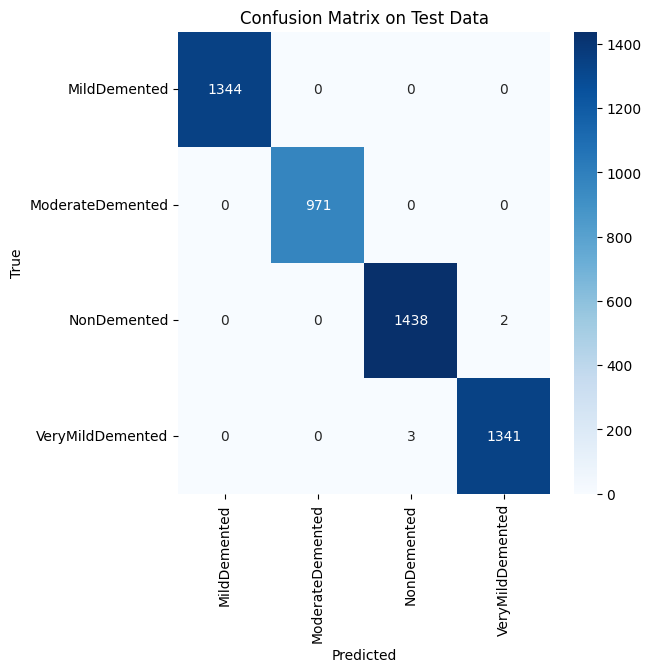

In [16]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Get true & predicted labels
y_true = np.concatenate([y for x, y in test_ds], axis=0)
y_pred_probs = model.predict(test_ds)
y_pred = np.argmax(y_pred_probs, axis=1)

# Report
print(classification_report(y_true, y_pred, target_names=class_names))

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix on Test Data")
plt.show()


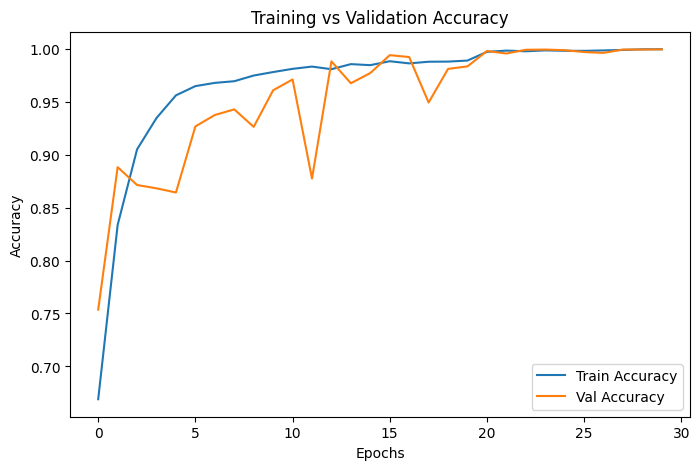

In [17]:
plt.figure(figsize=(8,5))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training vs Validation Accuracy')
plt.show()


In [19]:
# Save the model in the native Keras format
model.save("SE_ResNet50_VGG_Alzheimer_Model.keras")

# To load this model later, you will need to provide the custom objects:
# from tensorflow.keras.models import load_model
# loaded_model = load_model(
#     "SE_ResNet50_VGG_Alzheimer_Model.keras",
#     custom_objects={
#         'squeeze_excite_block': squeeze_excite_block,
#         'se_resnet50': se_resnet50,
#         'vgg_classifier': vgg_classifier
#     }
# )